In [9]:
import os
import numpy as np
import pandas as pd
import igraph as ig
from matplotlib import pyplot as plt

import final_project.config as c
from final_project.models.AdjacencyGraph import AdjacencyGraph

COLORS = ["#762a83", "#de77ae", "gold", "cyan", "#1b7837"]
POPULATION, SAMPLE = "Population", "Sample"

In [114]:
# Read Data:
loop_data = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "loop_stats.pkl"))
relative_covariances = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "keyframes_relative_covariances.pkl"))

pre_igraph = ig.Graph.Read_Pickle(os.path.join(c.DATA_WRITE_PATH, "posegraph_adjacency_pre_optimization.pkl"))
pre_adjacency_graph = AdjacencyGraph()
pre_adjacency_graph._graph = pre_igraph

post_igraph = ig.Graph.Read_Pickle(os.path.join(c.DATA_WRITE_PATH, "posegraph_adjacency_post_optimization.pkl"))
post_adjacency_graph = AdjacencyGraph()
post_adjacency_graph._graph = post_igraph

In [97]:
# Calculate Covariances & Determinants:
pre_vertex_ids = [pre_adjacency_graph.get_vertex_id(fr_idx) for fr_idx in relative_covariances.index if fr_idx != 0]
pre_covs = [pre_adjacency_graph.get_relative_covariance(0, v_id) for v_id in pre_vertex_ids]
pre_covs = pd.Series(pre_covs, name="Pre_Cov_igraph", index=relative_covariances.index[1:])

post_vertex_ids = [post_adjacency_graph.get_vertex_id(fr_idx) for fr_idx in relative_covariances.index if fr_idx != 0]
post_covs = [post_adjacency_graph.get_relative_covariance(0, v_id) for v_id in post_vertex_ids]
post_covs = pd.Series(post_covs, name="Post_Cov_igraph", index=relative_covariances.index[1:])

relative_covariances_igraph = pd.DataFrame([pre_covs, post_covs]).T
first_cov_series = relative_covariances.xs(0).rename(index=lambda col: [other_col for other_col in relative_covariances_igraph.columns if col in other_col][0])
relative_covariances_igraph = pd.concat([relative_covariances_igraph, first_cov_series.to_frame().T]).sort_index()

combined_covariance_df = pd.concat([relative_covariances, relative_covariances_igraph], axis=1)
rotation_determinants = combined_covariance_df.applymap(lambda cov: np.linalg.det(cov[:3, :3]))
location_determinants = combined_covariance_df.applymap(lambda cov: np.linalg.det(cov[3:, 3:]))

<Figure size 432x288 with 0 Axes>

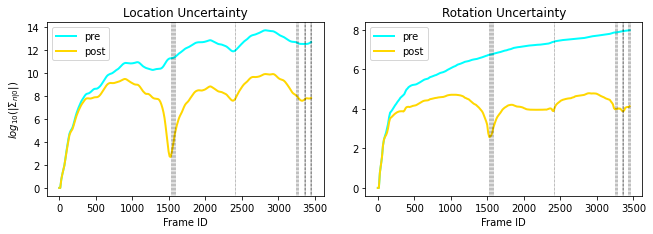

In [132]:
plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
fig.tight_layout()

axes[0].set_title("Location Uncertainty")
log_location_det = np.log10(location_determinants)
correction = log_location_det.min().min()
pre_data = log_location_det["Pre_Cov"] - correction
post_data = log_location_det["Post_Cov"] - correction
axes[0].plot(log_location_det.index, pre_data, label="pre", c=COLORS[3], linewidth=2)
axes[0].plot(log_location_det.index, post_data, label="post", c=COLORS[2], linewidth=2)
[axes[0].axvline(fr_id, c='k', linestyle=":", linewidth=0.5) for fr_id in loop_data["FrontFrame"]]
axes[0].set_ylabel("$log_{10}(|\Sigma_{n|0}|)$")
axes[0].set_xlabel("Frame ID")
axes[0].legend()

axes[1].set_title("Rotation Uncertainty")
log_rotation_det = np.log10(rotation_determinants)
correction = log_rotation_det.min().min()
pre_data = log_rotation_det["Pre_Cov"] - correction
post_data = log_rotation_det["Post_Cov"] - correction
axes[1].plot(log_rotation_det.index, pre_data, label="pre", c=COLORS[3], linewidth=2)
axes[1].plot(log_rotation_det.index, post_data, label="post", c=COLORS[2], linewidth=2)
[axes[1].axvline(fr_id, c='k', linestyle=":", linewidth=0.5) for fr_id in loop_data["FrontFrame"]]
# axes[1].set_ylabel("$log_{10}(|\Sigma|)$")
axes[1].set_xlabel("Frame ID")
axes[1].legend()

plt.show()

<Figure size 432x288 with 0 Axes>

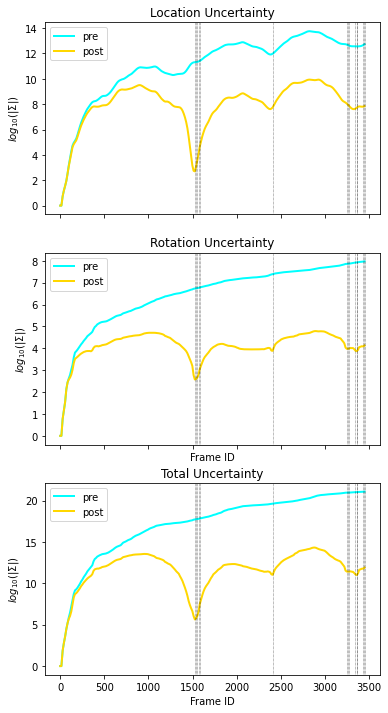

In [125]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(6, 12))
# fig.tight_layout()

axes[0].set_title("Location Uncertainty")
log_location_det = np.log10(location_determinants)
correction = log_location_det.min().min()
pre_data = log_location_det["Pre_Cov"] - correction
post_data = log_location_det["Post_Cov"] - correction
axes[0].plot(log_location_det.index, pre_data, label="pre", c=COLORS[3], linewidth=2)
axes[0].plot(log_location_det.index, post_data, label="post", c=COLORS[2], linewidth=2)
[axes[0].axvline(fr_id, c='k', linestyle=":", linewidth=0.5) for fr_id in loop_data["FrontFrame"]]
axes[0].set_ylabel("$log_{10}(|\Sigma|)$")
axes[0].legend()

axes[1].set_title("Rotation Uncertainty")
log_rotation_det = np.log10(rotation_determinants)
correction = log_rotation_det.min().min()
pre_data = log_rotation_det["Pre_Cov"] - correction
post_data = log_rotation_det["Post_Cov"] - correction
axes[1].plot(log_rotation_det.index, pre_data, label="pre", c=COLORS[3], linewidth=2)
axes[1].plot(log_rotation_det.index, post_data, label="post", c=COLORS[2], linewidth=2)
[axes[1].axvline(fr_id, c='k', linestyle=":", linewidth=0.5) for fr_id in loop_data["FrontFrame"]]
axes[1].set_ylabel("$log_{10}(|\Sigma|)$")
axes[1].set_xlabel("Frame ID")
axes[1].legend()

axes[2].set_title("Total Uncertainty")
determinants = combined_covariance_df.applymap(lambda cov: np.linalg.det(cov))
log_determinants = np.log10(determinants)
correction = log_determinants.min().min()
pre_data = log_determinants["Pre_Cov"] - correction
post_data = log_determinants["Post_Cov"] - correction
axes[2].plot(log_determinants.index, pre_data, label="pre", c=COLORS[3], linewidth=2)
axes[2].plot(log_determinants.index, post_data, label="post", c=COLORS[2], linewidth=2)
[axes[2].axvline(fr_id, c='k', linestyle=":", linewidth=0.5) for fr_id in loop_data["FrontFrame"]]
axes[2].set_ylabel("$log_{10}(|\Sigma|)$")
axes[2].set_xlabel("Frame ID")
axes[2].legend()

plt.show()